In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import PIL
from PIL import Image
import random
import os



In [2]:
random.seed(0)
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])


,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


Main Data Shape: (9896, 6)
Extra Data Shape: (10384, 4)
Common Columns: 
      InstanceID
      patientID
      ImageName
      isCancerous
Unique Main Columns: 
      cellType
      cellTypeName
Null Main Data: InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
Duplicated Main Data: 0
Images Duplicated:  0
Value counts for Iscancerous
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Percent size: 
0: 58.78132578819725
1: 41.21867421180275


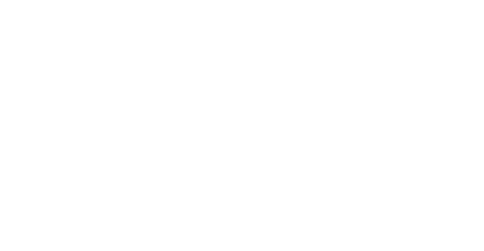

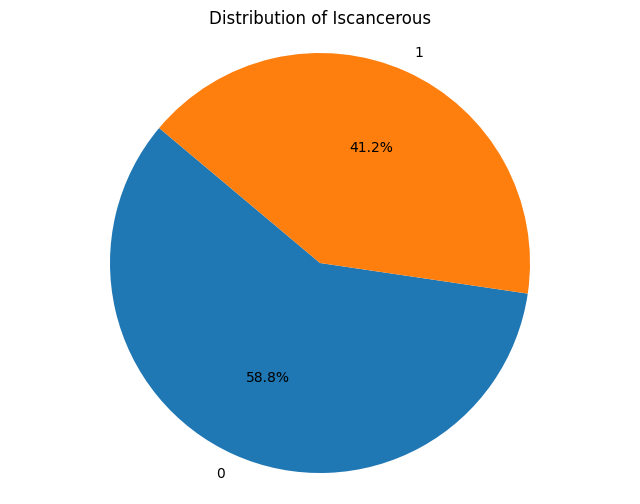

Value counts for Celltypename
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Percent size: 
Epithelial: 41.21867421180275
Inflammatory: 25.697251414713012
Fibroblast: 19.078415521422798
Others: 14.005658852061439


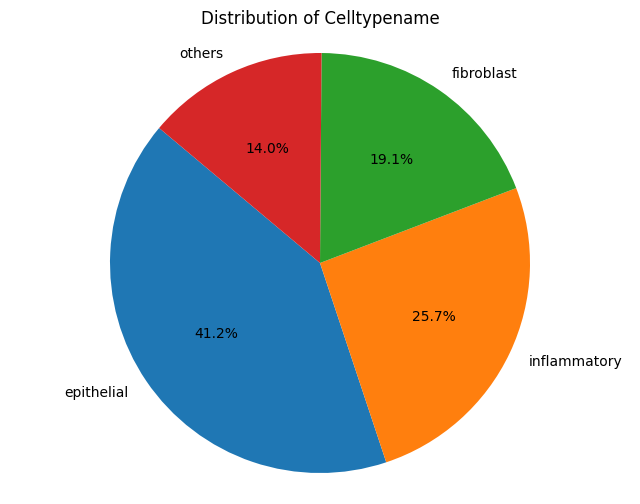

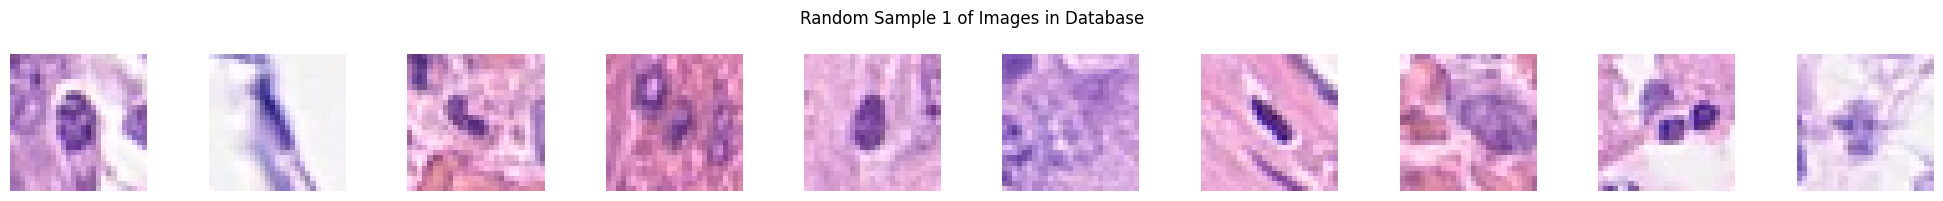

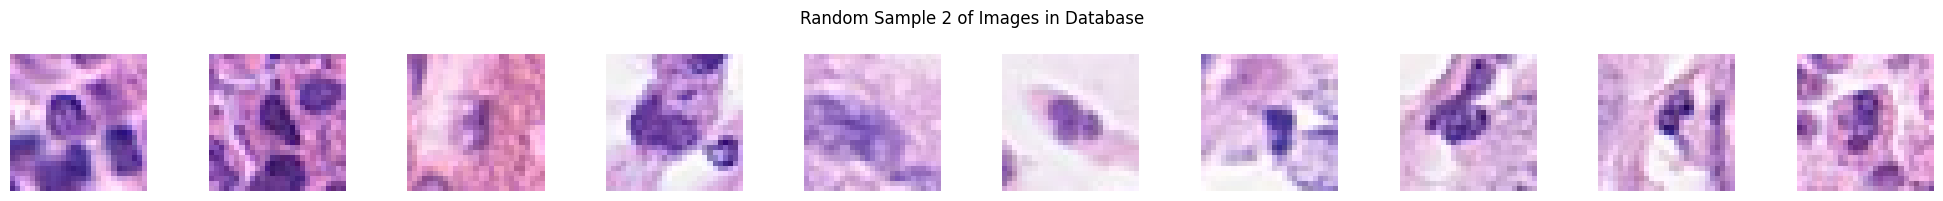

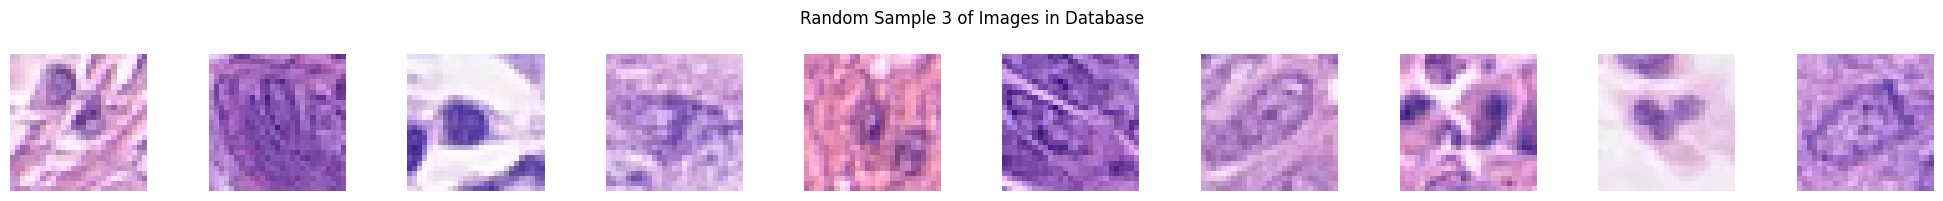

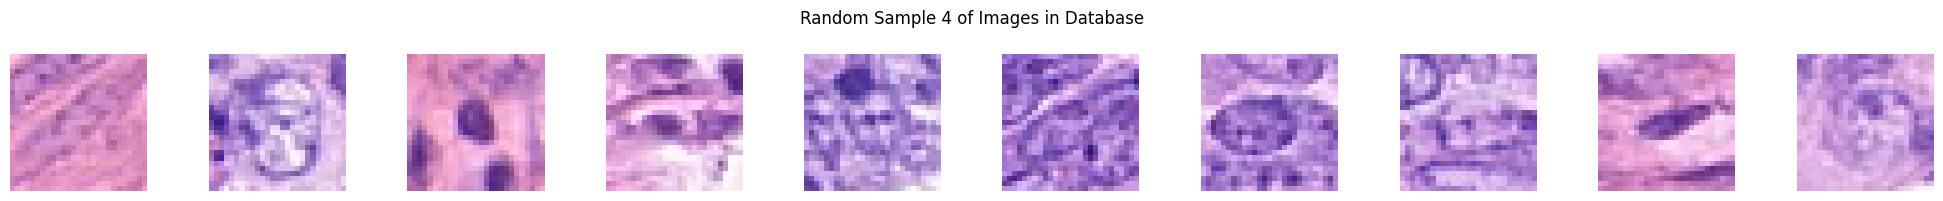

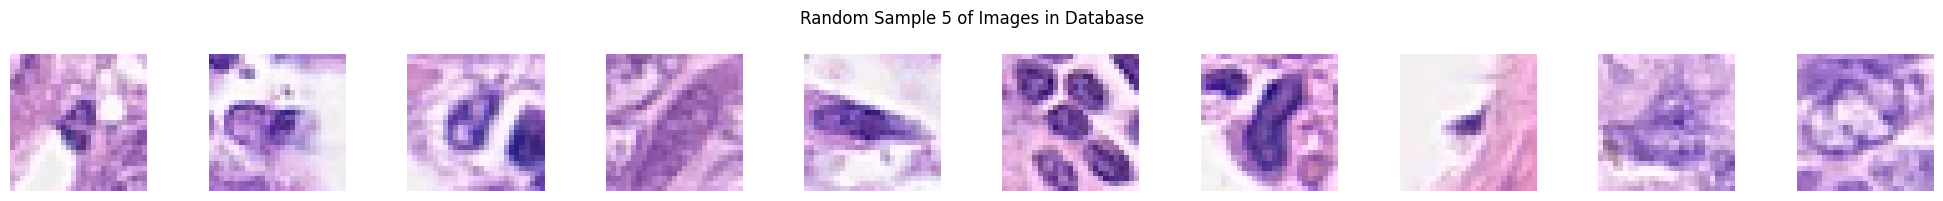

In [3]:
#EDA
fig, ax = plt.subplots(figsize=(6,3))
ax.axis("off")

#Structure and Size
print("Main Data Shape: " + str(data_main.shape))
print("Extra Data Shape: " + str(data_extra.shape))
print("Common Columns: ")

for column in data_main.columns.intersection(data_extra.columns):
    print("      "+ column)
print("Unique Main Columns: ")
for column in data_main.columns.symmetric_difference(data_extra.columns):
    print("      "+ column)

print("Null Main Data: " + str(data_main.isnull().sum()))
print("Duplicated Main Data: " + str(data_main.duplicated().sum()))
print("Images Duplicated:  " + str(data_main["ImageName"].duplicated().sum()))

#Value Counts
relevantColumns = ["isCancerous", "cellTypeName"]
for col in relevantColumns:
    print(f"Value counts for " + col.capitalize())
    value_counts = data_main[col].value_counts()
    print(value_counts)
    print("Percent size: " )
    
    for value, amount in data_main[col].value_counts().items():
        print(str(value).capitalize() + ": " + str((amount/len(data_main[col]))*100))
    
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.axis('equal')  
    plt.show()

pd.crosstab(data_main["cellTypeName"], data_main["isCancerous"])

#Random Sampling
dir = "./patch_images/" 
for i in range(1, 6):
    fig, axes = plt.subplots(1, 10, figsize=(20,2))
    fig.suptitle("Random Sample " + str(i) + " of Images in Database")
    sampledRows = data_main.sample(10)
    for j, ax in enumerate(axes):
        image_name = sampledRows.iloc[j]["ImageName"]
        img = np.asarray(Image.open(dir + image_name))
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [4]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

IMG_SIZE = 27
cell_type_counts = data_main["cellType"].value_counts().sort_index()
most_common_cell_type = cell_type_counts.idxmax()
print(most_common_cell_type)
max_value = cell_type_counts.max()
print(max_value)

cell_type_mapping = data_main.drop_duplicates(subset=["cellType"])[["cellType", "cellTypeName"]].sort_values("cellType")
cell_type_names = cell_type_mapping["cellTypeName"].values
cell_type_dict = dict(zip(cell_type_mapping["cellType"], cell_type_mapping["cellTypeName"]))
print(cell_type_dict)


cellType0Images = data_main[data_main["cellType"] == 0]["ImageName"].values
cellType1Images = data_main[data_main["cellType"] == 1]["ImageName"].values
cellType2Images = data_main[data_main["cellType"] == 2]["ImageName"].values
cellType3Images = data_main[data_main["cellType"] == 3]["ImageName"].values

imageCollections = []
imageCollections.append(cellType0Images)
imageCollections.append(cellType1Images)
imageCollections.append(cellType2Images)
imageCollections.append(cellType3Images)

data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
data_type_with_augmentation = data_type.copy()
cell_types_to_generate = cell_type_dict.copy()
del cell_types_to_generate[most_common_cell_type]
print(cell_types_to_generate)
dir = "./patch_images/"
for i, cellType in enumerate(cell_types_to_generate):
    cellTypeName = cell_type_dict[cellType]
    augDir = dir + "augmented_images/" + cellTypeName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    print(len(existing_aug) + len(imageCollections[i]))
    print(max_value)
    if not len(existing_aug) + len(imageCollections[i]) >= max_value:
        augmented_df = AugmentData(imageCollections[i], max_value, data_type, i, cell_type_dict[i])
        data_type_with_augmentation = pd.concat([data_type_with_augmentation, augmented_df], ignore_index=True)


2
4079
{0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}
{0: 'fibroblast', 1: 'inflammatory', 3: 'others'}
4079
4079
4079
4079
6772
4079


In [5]:

def AugmentData(imageNames ,maxCount, originalDF, label, labelName):
    
    counter = len(imageNames)

    augmentedRows = []
    
    dir = "./patch_images/"
    augDir = dir + "augmented_images/" + labelName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    existing_aug_count = len(existing_aug)
    counter += existing_aug_count
    print("Number of Files Detected: " + str(counter) + "Max Count: " + str(maxCount))
    if(counter >= maxCount):
        return

    # #Empty the directory
    # for fileName in os.listdir(augDir):
    #     file_path = os.path.join(augDir, fileName)
    #     if(os.path.isfile(file_path)):
    #         os.remove(file_path)

    
    while counter < maxCount:
        counter += 1
        #Pick and random image and open
        chosenImage = imageNames[random.randint(0, len(imageNames)-1)]
        openedImage = PIL.Image.open(dir + chosenImage).convert("RGB")
       
        #convert to data 
        image_np = np.array(openedImage)
        image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, 0)  # Add batch dimension
        
        data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        ])
        augmented_tensor = data_augmentation(image_tensor)
        augmented_image = tf.cast(tf.squeeze(augmented_tensor), tf.uint8).numpy()
        augmented_pil = PIL.Image.fromarray(augmented_image)

        augmentedImageName = "Augmented" + str(counter) +".png"
        save_path = os.path.join(augDir + augmentedImageName)
        augmented_pil.save(save_path)
        new_row = {"ImageName": augmentedImageName, "cellType": label, "cellTypeName": labelName}
        augmentedRows.append(new_row)
    
    return pd.DataFrame(augmentedRows)

In [6]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [7]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='max', restore_best_weights=True)

In [9]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [11]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


**MLP**

In [87]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

In [88]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [89]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.6786 - loss: 0.5975 - val_categorical_accuracy: 0.7219 - val_loss: 0.4949
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.7911 - loss: 0.4668 - val_categorical_accuracy: 0.8466 - val_loss: 0.4137
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8188 - loss: 0.4163 - val_categorical_accuracy: 0.8499 - val_loss: 0.3735
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8290 - loss: 0.3859 - val_categorical_accuracy: 0.8190 - val_loss: 0.4045
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8306 - loss: 0.3818 - val_categorical_accuracy: 0.8466 - val_loss: 0.3578
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8407 - loss: 0.3671 - val_categorical_accuracy: 0.8457 - val_loss: 0.3568
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8433 - loss: 0.3593 -

Early stopping is triggered at epoch 10 with the best weights being found at epoch 7 meaning running it for longer either will make results worse or have no impact

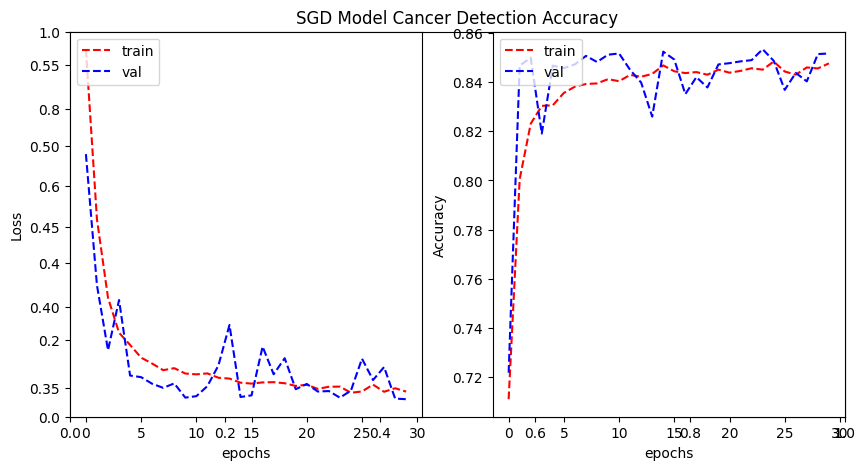

In [ ]:
plot_learning_curve("Base MLP Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [91]:
model.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - categorical_accuracy: 0.8565 - loss: 0.3376


[0.3460195064544678, 0.8520709872245789]

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [93]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [94]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - categorical_accuracy: 0.6759 - loss: 0.6687 - val_categorical_accuracy: 0.8356 - val_loss: 0.3907
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.7933 - loss: 0.4425 - val_categorical_accuracy: 0.7813 - val_loss: 0.4658
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8201 - loss: 0.3980 - val_categorical_accuracy: 0.6743 - val_loss: 0.6392
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8280 - loss: 0.3829 - val_categorical_accuracy: 0.8543 - val_loss: 0.3450
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8334 - loss: 0.3719 - val_categorical_accuracy: 0.8296 - val_loss: 0.3801
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8341 - loss: 0.3698 - val_categorical_accuracy: 0.8553 - val_loss: 0.3437
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8397 - lo

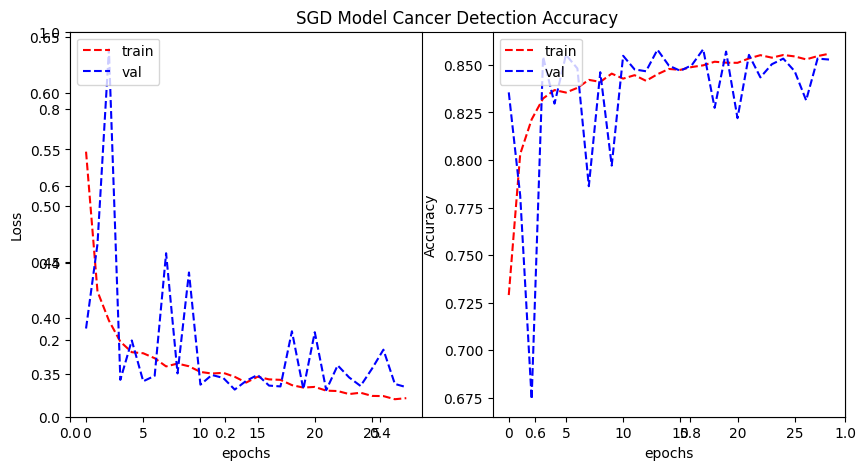

In [ ]:
plot_learning_curve("MLP with ReLu hidden layer activation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [96]:
model.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 885us/step - categorical_accuracy: 0.8540 - loss: 0.3422


[0.33678579330444336, 0.8570019602775574]

This model is slightly improved but by so little that it could be random varience, instead of using only an activation for the hidden layers we can have an activation for the output layer and use a single neuron with either isCancerous or not being determined by whether that neuron has been activated or not. We also can change the loss function to be binary crossentropy which allows us to utilise the single output layer neuron instead of needing 2 separate neurons. In order to do this we need to alter the data generators to be binary instead of categorical. We can also change our earlyStop to use accuracy instead of categorical accuracy to speed up execution time

In [97]:

batch_size = 27

train_generator_binary = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator_binary = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [ ]:
earlyStopBinary = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='max', restore_best_weights=True)

In [99]:
batch_size = 1

test_generator_binary = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 4056 validated image filenames belonging to 2 classes.


In [107]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [108]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [109]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6876 - loss: 0.5871 - val_accuracy: 0.8343 - val_loss: 0.3929
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8028 - loss: 0.4286 - val_accuracy: 0.8489 - val_loss: 0.3599
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8193 - loss: 0.4029 - val_accuracy: 0.8486 - val_loss: 0.3550
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8225 - loss: 0.3890 - val_accuracy: 0.8466 - val_loss: 0.3517
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8337 - loss: 0.3599 - val_accuracy: 0.8193 - val_loss: 0.3986
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8314 - loss: 0.3744 - val_accuracy: 0.8474 - val_loss: 0.3506
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8339 - loss: 0.3745 - val_accuracy: 0.8471 - val_loss: 0.3516
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8452 - loss: 0.3570 - val_a

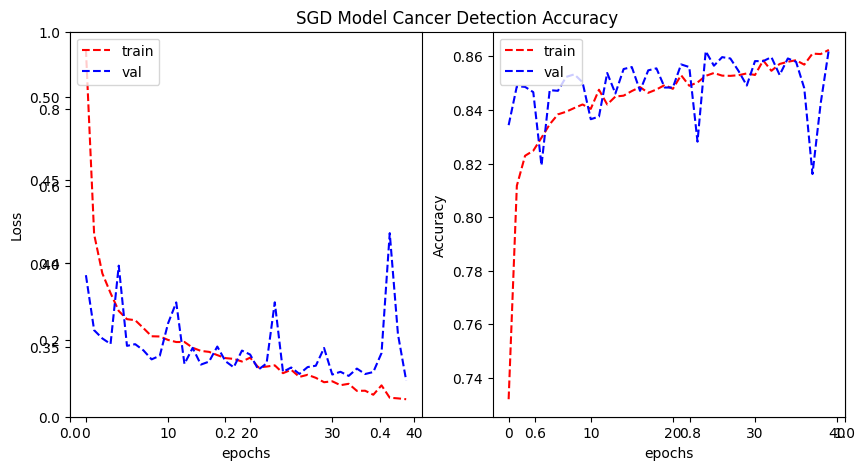

In [ ]:
plot_learning_curve("MLP with Relu Hidden and sigmoid output activation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [111]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 903us/step - accuracy: 0.8602 - loss: 0.3307


[0.33133140206336975, 0.8621794581413269]

This model so far is slightly improved but takes longer to train, however it does continue to climb further leading to around 1-2% more accuracy and less loss

In [112]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [113]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7017 - loss: 0.5734 - val_accuracy: 0.6815 - val_loss: 0.5757
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7948 - loss: 0.4451 - val_accuracy: 0.6277 - val_loss: 0.7030
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8205 - loss: 0.3963 - val_accuracy: 0.8531 - val_loss: 0.3503
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8270 - loss: 0.3776 - val_accuracy: 0.8333 - val_loss: 0.3738
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8350 - loss: 0.3717 - val_accuracy: 0.8563 - val_loss: 0.3433
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8406 - loss: 0.3648 - val_accuracy: 0.8378 - val_loss: 0.3641
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8370 - loss: 0.3595 - val_accuracy: 0.8439 - val_loss: 0.3586
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8388 - loss: 0.3633 - val_accura

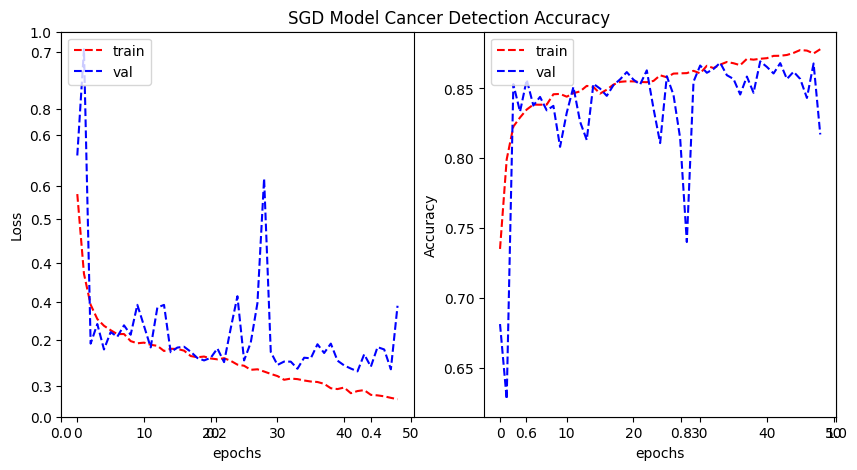

In [ ]:
plot_learning_curve("MLP with extra hidden layers added Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [116]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 928us/step - accuracy: 0.8582 - loss: 0.3374


[0.31009262800216675, 0.8717948794364929]

Once again there was a slight improvement of around 1% however this one took a lot longer to train and towards the end some slight overfitting is starting to show.

In [117]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [118]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [119]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7125 - loss: 0.5543 - val_accuracy: 0.8499 - val_loss: 0.3527
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8249 - loss: 0.3870 - val_accuracy: 0.8457 - val_loss: 0.3548
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8281 - loss: 0.3851 - val_accuracy: 0.7485 - val_loss: 0.5266
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8258 - loss: 0.3920 - val_accuracy: 0.7929 - val_loss: 0.4642
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8331 - loss: 0.3767 - val_accuracy: 0.8065 - val_loss: 0.4195
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8376 - loss: 0.3754 - val_accuracy: 0.8449 - val_loss: 0.3512
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8347 - loss: 0.3699 - val_accuracy: 0.8454 - val_loss: 0.3593
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8374 - loss: 0.3617 - val_accu

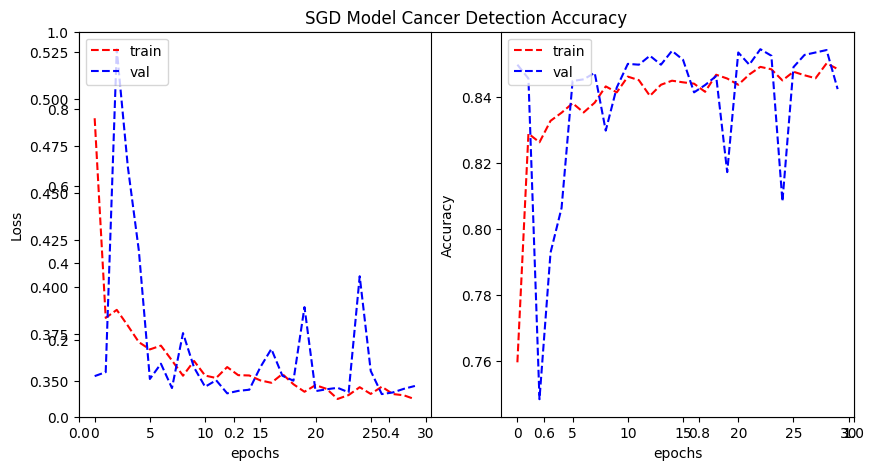

In [ ]:
plot_learning_curve("Modified optimiser for SGD Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [122]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 962us/step - accuracy: 0.8520 - loss: 0.3474


[0.34376123547554016, 0.8540433645248413]

This seems to negatively affect the model so we will not be continuing to use it, we can try using the adam optimiser to see if that helps but we may be nearing the limit of the MLP model

In [123]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [124]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [125]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7032 - loss: 0.6072 - val_accuracy: 0.8496 - val_loss: 0.3506
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8140 - loss: 0.4092 - val_accuracy: 0.8466 - val_loss: 0.3529
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8341 - loss: 0.3774 - val_accuracy: 0.8476 - val_loss: 0.3525
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8374 - loss: 0.3619 - val_accuracy: 0.8326 - val_loss: 0.3784
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8374 - loss: 0.3738 - val_accuracy: 0.8494 - val_loss: 0.3492
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8278 - loss: 0.3869 - val_accuracy: 0.8484 - val_loss: 0.3493
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8364 - loss: 0.3630 - val_accuracy: 0.8326 - val_loss: 0.3857
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8421 - loss: 0.3580 - 

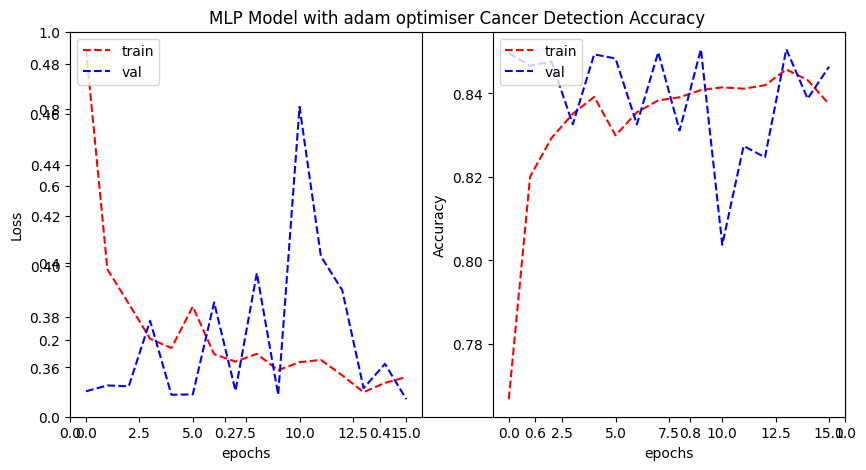

In [126]:
plot_learning_curve("MLP Model with adam optimiser Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [127]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 930us/step - accuracy: 0.8508 - loss: 0.3535


[0.3524605333805084, 0.8503451943397522]

The accuracy and loss for this one was all over the place but the best accuracy was sitting at the same value of 85% but the loss was sigificantly higher than the previous few models so from all this the optimal model was the extra hidden layers but before we started to alter the optimiser

**CNN**

In [ ]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - categorical_accuracy: 0.6330 - loss: 0.6827 - val_categorical_accuracy: 0.6573 - val_loss: 0.6434
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6616 - loss: 0.6440 - val_categorical_accuracy: 0.6573 - val_loss: 0.6476
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - categorical_accuracy: 0.6555 - loss: 0.6485 - val_categorical_accuracy: 0.6573 - val_loss: 0.6432
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.6569 - loss: 0.6483 - val_categorical_accuracy: 0.6573 - val_loss: 0.6475
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6489 - loss: 0.6511 - val_categorical_accuracy: 0.6573 - val_loss: 0.6453
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6537 - loss: 0.6481 - val_categorical_accuracy: 0.6573 - val_loss: 0.6435
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

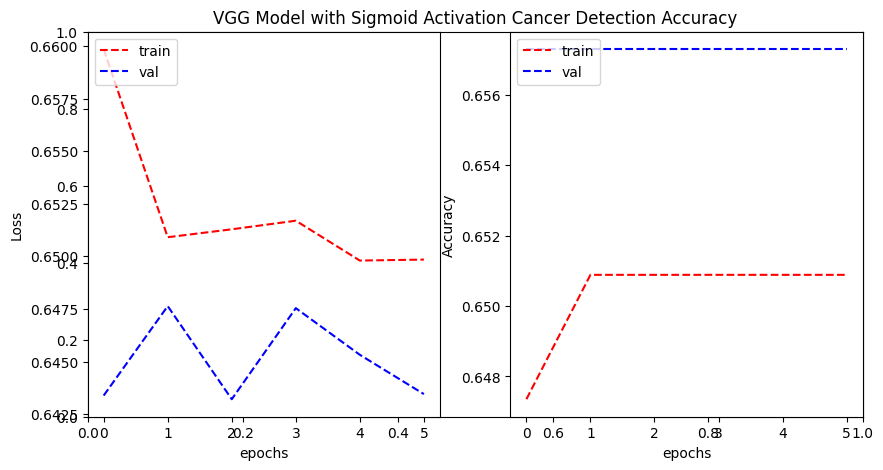

In [ ]:
plot_learning_curve("VGG Model with Sigmoid Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.6485 - loss: 0.6485


[0.6492437720298767, 0.6471893787384033]

After doing some research, using sigmoid for the hidden layers can lead to significant underfitting which is exactly what this looks like

In [ ]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - categorical_accuracy: 0.7082 - loss: 0.5692 - val_categorical_accuracy: 0.8538 - val_loss: 0.3448
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8422 - loss: 0.3707 - val_categorical_accuracy: 0.8708 - val_loss: 0.3231
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8602 - loss: 0.3262 - val_categorical_accuracy: 0.8720 - val_loss: 0.2976
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8771 - loss: 0.3005 - val_categorical_accuracy: 0.8780 - val_loss: 0.2863
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8767 - loss: 0.2930 - val_categorical_accuracy: 0.8881 - val_loss: 0.2772
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8898 - loss: 0.2764 - val_categorical_accuracy: 0.8617 - val_loss: 0.3196
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.880

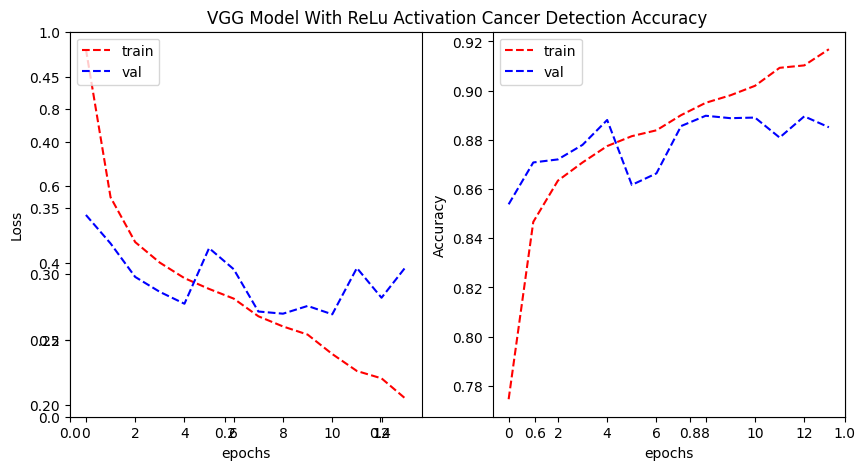

In [ ]:
plot_learning_curve("VGG Model With ReLu Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - categorical_accuracy: 0.8907 - loss: 0.2524


[0.25670331716537476, 0.8922584056854248]

Now it is clearly overfitting so we can start by simplifying the model as the images are relatively simple

In [ ]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7267 - loss: 0.5383 - val_categorical_accuracy: 0.8447 - val_loss: 0.3525
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8558 - loss: 0.3361 - val_categorical_accuracy: 0.8858 - val_loss: 0.2819
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8727 - loss: 0.3080 - val_categorical_accuracy: 0.8691 - val_loss: 0.3178
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8710 - loss: 0.2963 - val_categorical_accuracy: 0.8895 - val_loss: 0.2823
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8815 - loss: 0.2854 - val_categorical_accuracy: 0.8863 - val_loss: 0.2821
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8917 - loss: 0.2605 - val_categorical_accuracy: 0.8905 - val_loss: 0.2645
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.894

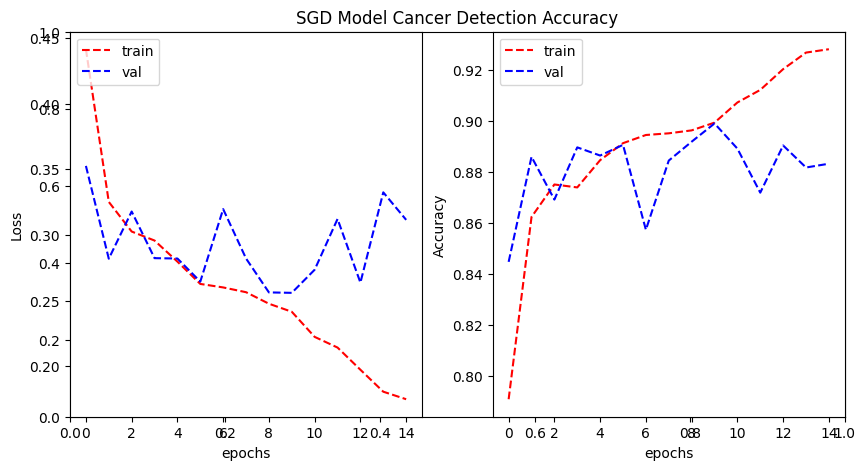

In [ ]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.8972 - loss: 0.2538


[0.249080628156662, 0.9001479148864746]

The model is still overfitting but less so, now we can try regularisation

In [ ]:
from tensorflow.keras import regularizers
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7513 - loss: 0.5965 - val_categorical_accuracy: 0.8131 - val_loss: 0.4700
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8438 - loss: 0.4104 - val_categorical_accuracy: 0.8501 - val_loss: 0.3844
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8534 - loss: 0.3848 - val_categorical_accuracy: 0.8674 - val_loss: 0.3525
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8675 - loss: 0.3551 - val_categorical_accuracy: 0.8748 - val_loss: 0.3352
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8674 - loss: 0.3537 - val_categorical_accuracy: 0.8770 - val_loss: 0.3477
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8793 - loss: 0.3395 - val_categorical_accuracy: 0.8360 - val_loss: 0.4101
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - categorical_accuracy: 0.869

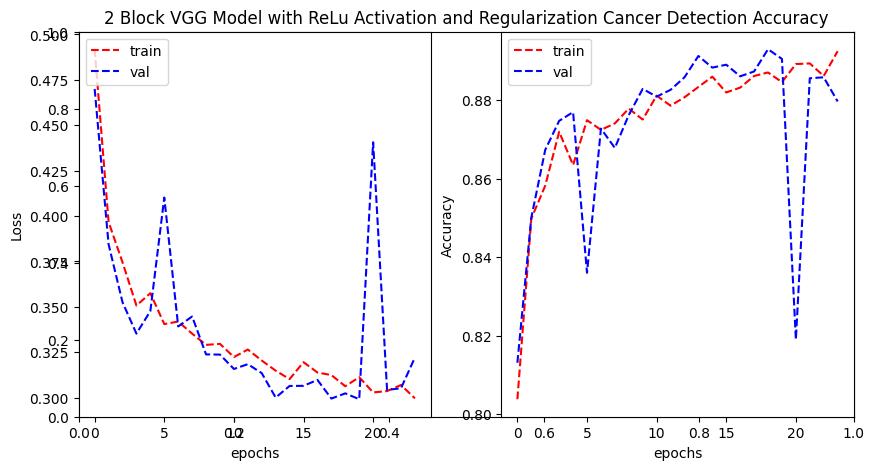

In [ ]:
plot_learning_curve("2 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.8922 - loss: 0.2925


[0.29099905490875244, 0.8912721872329712]

This very clearly has worked so now we can try to add back the other hidden block and see if the model can handle it now or if it still is too complex for the task

In [ ]:

model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - categorical_accuracy: 0.7469 - loss: 0.6902 - val_categorical_accuracy: 0.8548 - val_loss: 0.4025
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8501 - loss: 0.4146 - val_categorical_accuracy: 0.8454 - val_loss: 0.4194
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8606 - loss: 0.3765 - val_categorical_accuracy: 0.8735 - val_loss: 0.3425
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8638 - loss: 0.3640 - val_categorical_accuracy: 0.8711 - val_loss: 0.3455
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8663 - loss: 0.3616 - val_categorical_accuracy: 0.8481 - val_loss: 0.3887
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8667 - loss: 0.3469 - val_categorical_accuracy: 0.8851 - val_loss: 0.3201
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.874

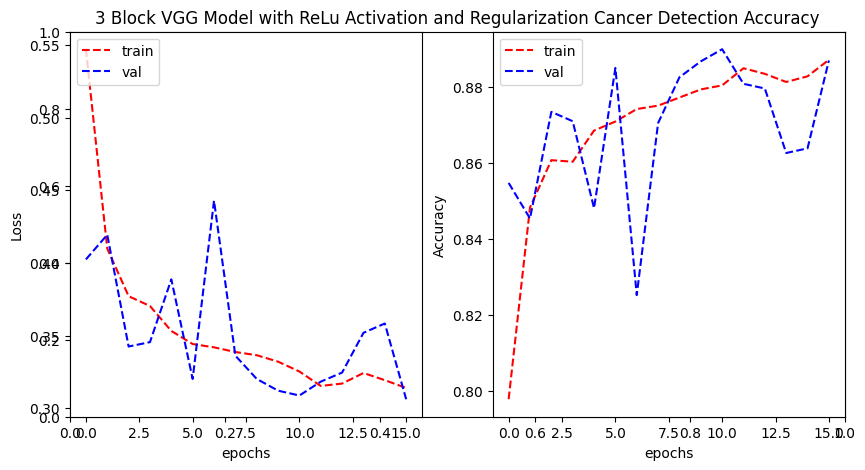

In [ ]:
plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.8835 - loss: 0.3066


[0.2971968948841095, 0.891765296459198]

Clasification

In [12]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
print(data_type)

      InstanceID  patientID  ImageName  cellType
0          22405          1  22405.png         0
1          22406          1  22406.png         0
2          22407          1  22407.png         0
3          22408          1  22408.png         0
4          22409          1  22409.png         0
...          ...        ...        ...       ...
9891        1625         60   1625.png         2
9892        1626         60   1626.png         2
9893        1627         60   1627.png         2
9894        1628         60   1628.png         2
9895        1629         60   1629.png         2

[9896 rows x 4 columns]


In [13]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [14]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [25]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


MLP

In [21]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [22]:
model_classification.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [23]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - categorical_accuracy: 0.4331 - loss: 1.7208 - val_categorical_accuracy: 0.4219 - val_loss: 1.1657
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6123 - loss: 0.9755 - val_categorical_accuracy: 0.6013 - val_loss: 0.9128
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6245 - loss: 0.9368 - val_categorical_accuracy: 0.6625 - val_loss: 0.8373
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.6788 - loss: 0.8202 - val_categorical_accuracy: 0.6877 - val_loss: 0.7953
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6710 - loss: 0.8630 - val_categorical_accuracy: 0.6731 - val_loss: 0.8367
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6728 - loss: 0.8398 - val_categorical_accuracy: 0.6347 - val_loss: 0.9444
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.671

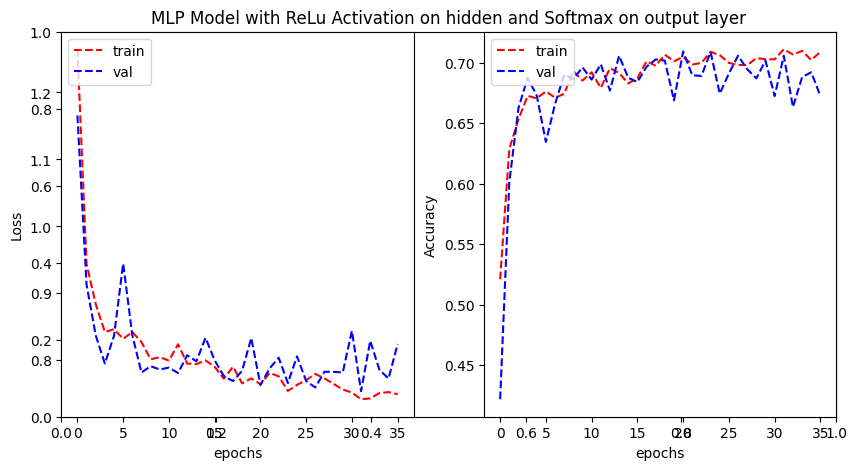

 168/1980 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - categorical_accuracy: 0.7660 - loss: 0.6756

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 867us/step - categorical_accuracy: 0.7154 - loss: 0.7694


[0.8013509511947632, 0.7020202279090881]

In [26]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

It is a decent start with the model reaching a decent accuracy for a more complex problem however it has quite a high loss which can be improved upon. We can try adding complexity to the model with more layers to try to better fit the more complex classifer

In [27]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [28]:
model_classification.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [29]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.4068 - loss: 1.5070 - val_categorical_accuracy: 0.5675 - val_loss: 0.9978
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6241 - loss: 0.9579 - val_categorical_accuracy: 0.6266 - val_loss: 0.9114
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6475 - loss: 0.9085 - val_categorical_accuracy: 0.7100 - val_loss: 0.7787
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6790 - loss: 0.8189 - val_categorical_accuracy: 0.6933 - val_loss: 0.8025
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6522 - loss: 0.8703 - val_categorical_accuracy: 0.6225 - val_loss: 0.9641
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6748 - loss: 0.8249 - val_categorical_accuracy: 0.6923 - val_loss: 0.8108
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.692

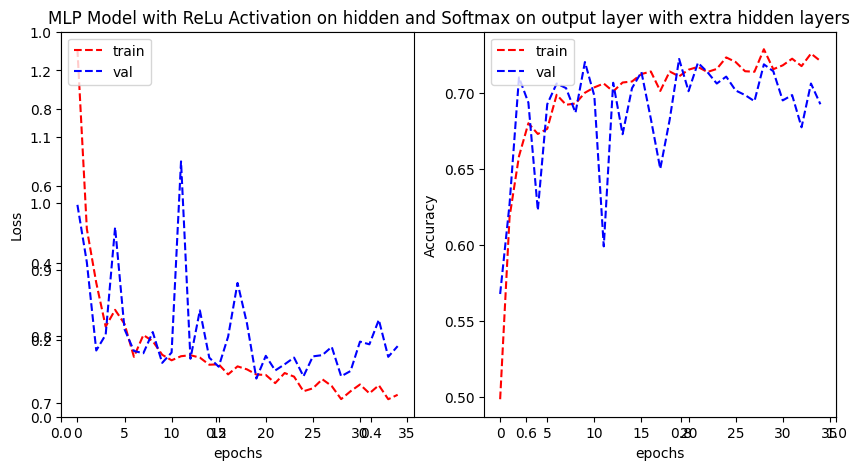

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step - categorical_accuracy: 0.7194 - loss: 0.7468


[0.7573760151863098, 0.7090908885002136]

In [30]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer with extra hidden layers", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

The loss is a little improved so we can add even more hidden layers to see if that improves either the loss or the accuracy

In [35]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [36]:
model_classification.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [37]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - categorical_accuracy: 0.3943 - loss: 1.4720 - val_categorical_accuracy: 0.5457 - val_loss: 1.0464
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.5863 - loss: 0.9964 - val_categorical_accuracy: 0.6675 - val_loss: 0.8703
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.6173 - loss: 0.9481 - val_categorical_accuracy: 0.6422 - val_loss: 0.8701
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.6597 - loss: 0.8511 - val_categorical_accuracy: 0.6771 - val_loss: 0.8309
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.6919 - loss: 0.8106 - val_categorical_accuracy: 0.6564 - val_loss: 0.8623
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.6953 - loss: 0.7998 - val_categorical_accuracy: 0.6857 - val_loss: 0.7942
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.680

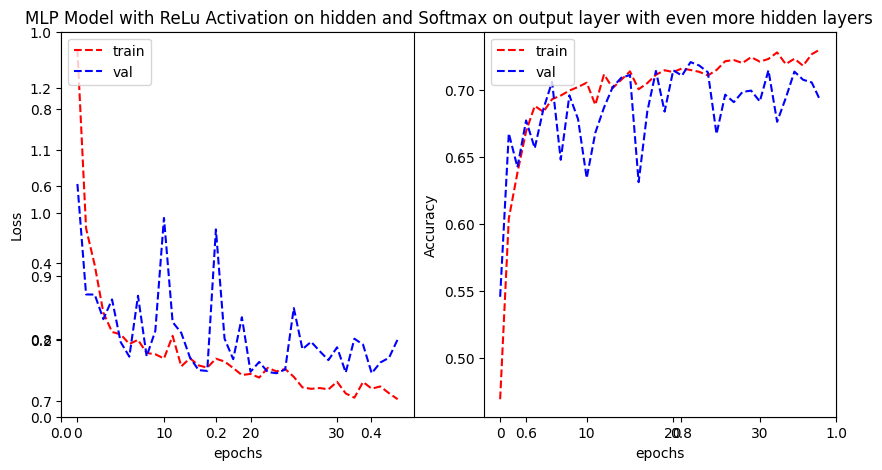

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.7081 - loss: 0.7685


[0.7828490138053894, 0.7090908885002136]

In [40]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer with even more hidden layers", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

The accuracy is the exact same as the 3 layer NN however the loss is higher and it appears to begin overfitting plus it takes longer to train so the extra layer did not help but made the model worse

CNN

In [ ]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_VGG_1_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [ ]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_softmax = model_VGG_1_softmax.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - categorical_accuracy: 0.4981 - loss: 1.1712 - val_categorical_accuracy: 0.6948 - val_loss: 0.7917
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6851 - loss: 0.8041 - val_categorical_accuracy: 0.6594 - val_loss: 0.8371
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7247 - loss: 0.7135 - val_categorical_accuracy: 0.7054 - val_loss: 0.7274
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7338 - loss: 0.6914 - val_categorical_accuracy: 0.7448 - val_loss: 0.6743
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7457 - loss: 0.6528 - val_categorical_accuracy: 0.7337 - val_loss: 0.6745
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7527 - loss: 0.6445 - val_categorical_accuracy: 0.7585 - val_loss: 0.6247
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7657 - loss: 0

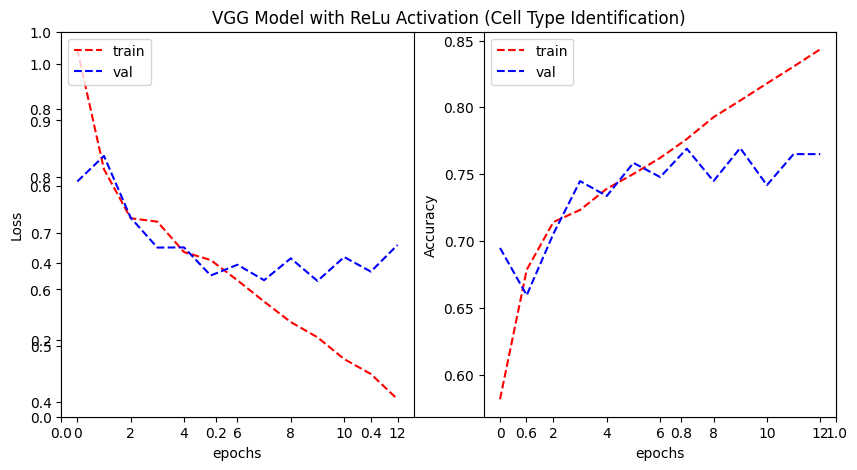

 105/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.8136 - loss: 0.5521

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.7468 - loss: 0.6544


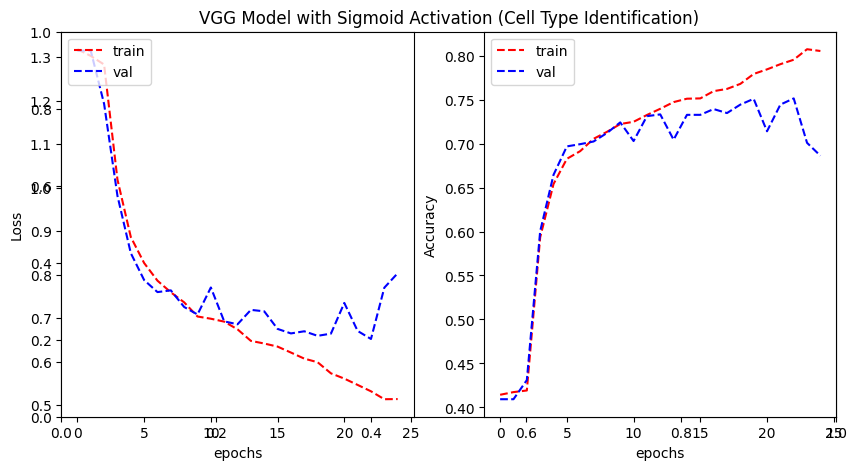

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.7267 - loss: 0.7087


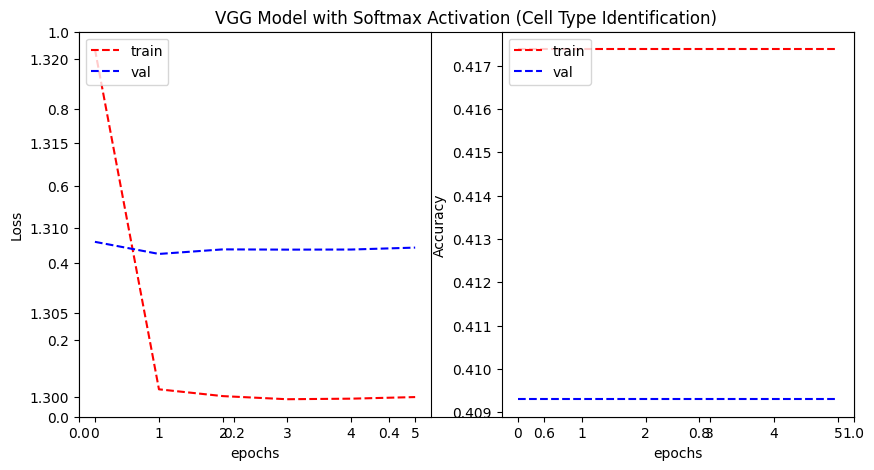

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.3886 - loss: 1.3252


[1.320934772491455, 0.3994949460029602]

In [ ]:
plot_learning_curve("VGG Model with ReLu Activation (Cell Type Identification)",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)
plot_learning_curve("VGG Model with Sigmoid Activation (Cell Type Identification)",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)

plot_learning_curve("VGG Model with Softmax Activation (Cell Type Identification)",history_VGG_1_softmax.history['loss'], history_VGG_1_softmax.history['val_loss'], 
                    history_VGG_1_softmax.history['categorical_accuracy'], history_VGG_1_softmax.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax.evaluate(test_generator)


This shows a significant amount of overfitting, due to the model learning valuing irrelevant features like noise resulting in worse performance with new data. Softmax is having the same issue of underfitting that using only sigmoid for all hidden layers is having so it is worth testing with relu for hidden and softmax for the final layer

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    # preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.2),
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - categorical_accuracy: 0.4680 - loss: 1.3264 - val_categorical_accuracy: 0.6645 - val_loss: 0.9371
Epoch 2/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6667 - loss: 0.9278 - val_categorical_accuracy: 0.6882 - val_loss: 0.8256
Epoch 3/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6852 - loss: 0.8647 - val_categorical_accuracy: 0.6882 - val_loss: 0.8130
Epoch 4/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7007 - loss: 0.7952 - val_categorical_accuracy: 0.7256 - val_loss: 0.7442
Epoch 5/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7343 - loss: 0.7361 - val_categorical_accuracy: 0.7514 - val_loss: 0.7135
Epoch 6/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7408 - loss: 0.7336 - val_categorical_accuracy: 0.7292 - val_loss: 0.7369
Epoch 7/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.747

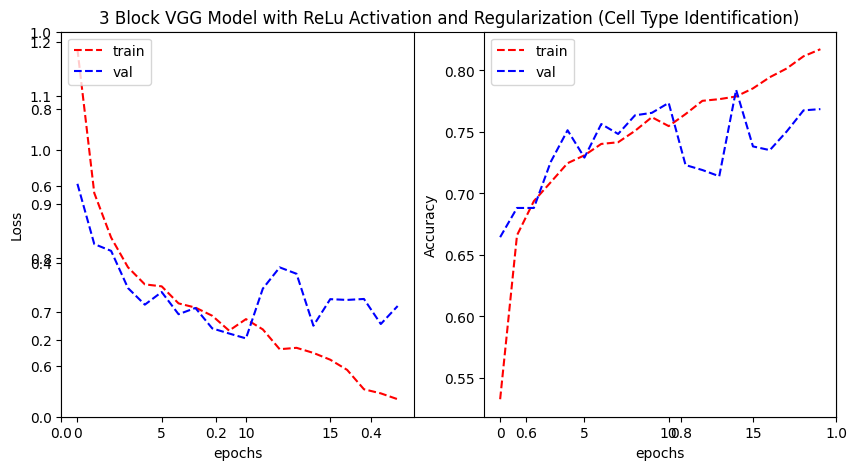

In [ ]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=25, callbacks=earlyStop, verbose=1)

plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization (Cell Type Identification)", history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Significantly better results just with regularization, will try to fit better later

In [ ]:
#Using extra data to  improve the cell type classification
extra_data_for_type = data_extra[["InstanceID", "patientID", "ImageName"]]

def preprocess_image(filename, img_dir="./patch_images/"):
    path = os.path.join(img_dir, filename)
    image = Image.open(path).convert("RGB")
    image = image.resize((27, 27))
    image_array = np.array(image).astype(np.float32) / 255.0
    return image_array

X_extra = np.array([
    preprocess_image(name) for name in extra_data_for_type["ImageName"]
])

predictions = model_VGG_2.predict(X_extra)
predicted_classes = np.argmax(predictions, axis=1)

label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
predicted_labels = [label_dict[i] for i in predicted_classes]

extra_data_for_type["predicted_cellType"] = predicted_labels

extra_data_for_type.to_csv("extra_data_with_predictions.csv", index=False)

NameError: name 'model_VGG_2' is not defined

In [ ]:
extra_data_with_predictions = pd.read_csv("extra_data_with_predictions.csv")
extra_data_with_predictions["isCancerous"] = data_extra["isCancerous"]
print(extra_data_with_predictions)
print(data_main)
label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
reverse_dict = {v: k for k, v in label_dict.items()}
newData = pd.concat([data_main, extra_data_with_predictions])
newData["cellTypeName" ] = newData["cellTypeName"].fillna(newData["predicted_cellType"])
newData["cellType"] = newData["cellType"].fillna(newData["cellTypeName"].map(reverse_dict))
newData = newData.drop(columns=["predicted_cellType"])
#Just need to plug this into the cancerous model and compare results
print(newData) 


       InstanceID  patientID  ImageName predicted_cellType  isCancerous
0           12681         61  12681.png         fibroblast            0
1           12682         61  12682.png         fibroblast            0
2           12683         61  12683.png         lymphocyte            0
3           12684         61  12684.png         fibroblast            0
4           12685         61  12685.png         fibroblast            0
...           ...        ...        ...                ...          ...
10379       20028         99  20028.png         fibroblast            0
10380       20029         99  20029.png         fibroblast            0
10381       20030         99  20030.png         fibroblast            0
10382       20031         99  20031.png         neutrophil            0
10383       20032         99  20032.png         lymphocyte            0

[10384 rows x 5 columns]
      InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.